In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
conn = sqlite3.connect('olap_assignment.db') 
cur = conn.cursor()

In [3]:
# Create tables
cur.executescript("""
DROP TABLE IF EXISTS sales;
DROP TABLE IF EXISTS products;
DROP TABLE IF EXISTS dates;

CREATE TABLE products (
  product_id INTEGER PRIMARY KEY,
  category TEXT NOT NULL,
  name TEXT NOT NULL,
  price REAL NOT NULL
);

CREATE TABLE dates (
  date TEXT PRIMARY KEY,          -- ISO format YYYY-MM-DD
  year INTEGER,
  quarter INTEGER,
  month INTEGER
);

CREATE TABLE sales (
  sale_id INTEGER PRIMARY KEY AUTOINCREMENT,
  date TEXT,
  product_id INTEGER,
  quantity INTEGER,
  revenue REAL,
  FOREIGN KEY(date) REFERENCES dates(date),
  FOREIGN KEY(product_id) REFERENCES products(product_id)
);
""")
conn.commit()

In [5]:
# Insert products
products = [
    (1, 'Electronics', 'Smartphone X', 399.0),
    (2, 'Electronics', 'Laptop Pro', 999.0),
    (3, 'Home', 'Blender', 59.0),
    (4, 'Home', 'Vacuum', 149.0),
    (5, 'Fashion', 'Sneakers', 89.0),
    (6, 'Fashion', 'Jacket', 119.0)
]

cur.executemany("INSERT INTO products(product_id, category, name, price) VALUES (?, ?, ?, ?);", products)
conn.commit()

In [8]:
# Insert dates for 2023 and 2024 
from datetime import date, timedelta

start = date(2023, 10, 1)
end = date(2024, 12, 31)
delta = timedelta(days=1)
d = start
dates_to_insert = []
while d <= end:
    dates_to_insert.append((d.isoformat(), d.year, (d.month-1)//3 + 1, d.month))
    d += delta

cur.executemany("INSERT OR IGNORE INTO dates(date, year, quarter, month) VALUES (?, ?, ?, ?);", dates_to_insert)
conn.commit()

In [9]:
# Insert sales data 
np.random.seed(42)
sales_rows = []
all_dates = [r[0] for r in dates_to_insert]
product_ids = [p[0] for p in products]

# create 600 sales rows randomly distributed across the date range
for _ in range(600):
    d = np.random.choice(all_dates)
    pid = int(np.random.choice(product_ids))
    qty = int(np.random.poisson(lam=2)) + 1

    # get product price from table
    price = next(p[3] for p in products if p[0] == pid)
    revenue = round(qty * price * (1 + np.random.normal(0, 0.05)), 2)  
    sales_rows.append((d, pid, qty, revenue))

cur.executemany("INSERT INTO sales(date, product_id, quantity, revenue) VALUES (?, ?, ?, ?);", sales_rows)
conn.commit()

In [10]:
pd.read_sql_query("SELECT COUNT(*) AS sales_count FROM sales;", conn)

,sales_count
0,600


## ROLAP: SQL OLAP queries
ROLAP = do aggregations in SQL.

In [11]:
# Average revenue by product category
query1 = """
SELECT p.category,
       COUNT(s.sale_id) AS num_sales,
       ROUND(AVG(s.revenue),2) AS avg_revenue,
       ROUND(SUM(s.revenue),2) AS total_revenue
FROM sales s
JOIN products p ON s.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC;
"""
df_q1 = pd.read_sql_query(query1, conn)
df_q1

,category,num_sales,avg_revenue,total_revenue
0,Electronics,190,2080.87,395365.93
1,Home,209,299.68,62632.46
2,Fashion,201,309.69,62248.10


In [13]:
# Total sales (sum of revenue) by year
query2 = """
SELECT d.year,
       COUNT(s.sale_id) AS num_sales,
       ROUND(SUM(s.revenue),2) AS total_revenue
FROM sales s
JOIN dates d ON s.date = d.date
GROUP BY d.year
ORDER BY d.year;
"""
df_q2 = pd.read_sql_query(query2, conn)
df_q2

,year,num_sales,total_revenue
0,2023,113,89983.76
1,2024,487,430262.73


In [15]:
# Best-selling product in each category (by total revenue)
query3 = """
SELECT category, name, total_revenue FROM (
  SELECT p.category, p.name, ROUND(SUM(s.revenue),2) AS total_revenue,
         ROW_NUMBER() OVER (PARTITION BY p.category ORDER BY SUM(s.revenue) DESC) as rn
  FROM sales s
  JOIN products p ON s.product_id = p.product_id
  GROUP BY p.category, p.name
) WHERE rn = 1
ORDER BY category;
"""
df_q3 = pd.read_sql_query(query3, conn)
df_q3

,category,name,total_revenue
0,Electronics,Laptop Pro,274819.58
1,Fashion,Jacket,35213.01
2,Home,Vacuum,44472.79


Query1: SQL GROUP BY on category to get averages and totals (ROLAP).

Query2: Aggregate by year to see year-over-year revenue.

Query3: Uses window function ROW_NUMBER to pick top product per category.



## MOLAP: Build a cube with pandas pivot_table

In [16]:
# Build a revenue cube: category x year (sum of revenue)
sales_df = pd.read_sql_query("""
SELECT s.*, p.category, p.name, d.year, d.quarter, d.month
FROM sales s
JOIN products p ON s.product_id = p.product_id
JOIN dates d ON s.date = d.date
""", conn)

cube = pd.pivot_table(sales_df, 
                      values='revenue',
                      index='category',
                      columns='year',
                      aggfunc='sum',
                      margins=True,           
                      margins_name='All', 
                      fill_value=0)
cube

year,2023,2024,All
category,,,
Electronics,67610.94,327754.99,395365.93
Fashion,8710.73,53537.37,62248.10
Home,13662.09,48970.37,62632.46
All,89983.76,430262.73,520246.49


MOLAP: the cube is materialized in pandas pivot table (fast, in-memory aggregations).

## HOLAP: Hybrid approach (detailed rows from SQL, aggregates with pandas)

In [17]:
# HOLAP pattern
# fetch detailed rows for a subset (ROLAP)
detailed = pd.read_sql_query("""
SELECT s.sale_id, s.date, p.category, p.name, s.quantity, s.revenue
FROM sales s JOIN products p ON s.product_id = p.product_id
WHERE s.date BETWEEN '2024-01-01' AND '2024-12-31';
""", conn)

# build aggregated summaries in pandas (MOLAP)
holap_summary = detailed.groupby(['category','name']).revenue.agg(
    total_revenue='sum', avg_revenue='mean', total_qty='sum').reset_index().sort_values('total_revenue', ascending=False)
detailed.head(), holap_summary.head()

(   sale_id        date category     name  quantity  revenue
 0        1  2024-01-11     Home   Vacuum         4   604.32
 1        2  2024-02-29     Home  Blender         1    61.98
 2        3  2024-06-14     Home   Vacuum         2   298.33
 3        4  2024-03-18     Home   Vacuum         3   437.44
 4        5  2024-12-19     Home  Blender         5   290.67,
       category          name  total_revenue  avg_revenue  total_qty
 0  Electronics    Laptop Pro      233704.47  3436.830441  233704.47
 1  Electronics  Smartphone X       94050.52  1133.138795   94050.52
 5         Home        Vacuum       34712.81   408.386000   34712.81
 2      Fashion        Jacket       31181.68   384.959012   31181.68
 3      Fashion      Sneakers       22355.69   254.041932   22355.69)

HOLAP fetches raw detailed rows from the relational store and builds fast in-memory summaries with pandas.



## OLAP operations: Slice, Dice, Roll-Up, Drill-Down
### Slice: fix one dimension (sales in 2024)

In [18]:
# Slice - sales in 2024 only
slice_2024 = sales_df[sales_df['year'] == 2024]
slice_2024_agg = slice_2024.groupby('category').revenue.agg(total_revenue='sum', num_sales='count').reset_index()
slice_2024_agg

,category,total_revenue,num_sales
0,Electronics,327754.99,151
1,Fashion,53537.37,169
2,Home,48970.37,167


We fixed the year dimension to 2024.

### Dice: multiple filters (Q1 2024 for Electronics only)

In [19]:
# Dice - Q1 2024 & Electronics
dice = sales_df[(sales_df['year'] == 2024) & (sales_df['quarter'] == 1) & (sales_df['category'] == 'Electronics')]
dice_agg = dice.groupby(['name']).revenue.agg(total_revenue='sum', num_sales='count').reset_index().sort_values('total_revenue', ascending=False)
dice_agg

,name,total_revenue,num_sales
0,Laptop Pro,74574.60,21
1,Smartphone X,29879.85,23


We applied multiple criteria across year, quarter and category.

### Roll-Up: Aggregate from product -> category -> year

In [20]:
# Roll-Up
# Level 1: product level (name)
roll_prod = sales_df.groupby(['year','category','name']).revenue.sum().reset_index().rename(columns={'revenue':'total_revenue'})
# Level 2: category
roll_cat = roll_prod.groupby(['year','category']).total_revenue.sum().reset_index().rename(columns={'total_revenue':'category_revenue'})
# Level 3: year 
roll_year = roll_cat.groupby(['year']).category_revenue.sum().reset_index().rename(columns={'category_revenue':'year_revenue'})

roll_prod.head(), roll_cat.head(), roll_year

(   year     category          name  total_revenue
 0  2023  Electronics    Laptop Pro       41115.11
 1  2023  Electronics  Smartphone X       26495.83
 2  2023      Fashion        Jacket        4031.33
 3  2023      Fashion      Sneakers        4679.40
 4  2023         Home       Blender        3902.11,
    year     category  category_revenue
 0  2023  Electronics          67610.94
 1  2023      Fashion           8710.73
 2  2023         Home          13662.09
 3  2024  Electronics         327754.99
 4  2024      Fashion          53537.37,
    year  year_revenue
 0  2023      89983.76
 1  2024     430262.73)

Roll-up aggregates up the hierarchy: product → category → year.

### Drill-Down: From year → quarter → month (expand)

In [21]:
# Drill-Down from year to quarter to month
# Start: by year
by_year = sales_df.groupby('year').revenue.sum().reset_index().rename(columns={'revenue':'revenue'})
# drill to quarter
by_quarter = sales_df.groupby(['year','quarter']).revenue.sum().reset_index().rename(columns={'revenue':'revenue'})
# drill to month
by_month = sales_df.groupby(['year','month']).revenue.sum().reset_index().rename(columns={'revenue':'revenue'})

by_year, by_quarter.head(), by_month.head(12)

(   year    revenue
 0  2023   89983.76
 1  2024  430262.73,
    year  quarter    revenue
 0  2023        4   89983.76
 1  2024        1  129781.02
 2  2024        2  100528.10
 3  2024        3  116224.56
 4  2024        4   83729.05,
     year  month   revenue
 0   2023     10  24498.23
 1   2023     11  40769.03
 2   2023     12  24716.50
 3   2024      1  50980.34
 4   2024      2  30374.22
 5   2024      3  48426.46
 6   2024      4  25282.75
 7   2024      5  53766.45
 8   2024      6  21478.90
 9   2024      7  47636.41
 10  2024      8  41137.35
 11  2024      9  27450.80)

Drill-down splits aggregate to more granular levels (year → quarter → month).



## Visualizations 
### Plot 1 — Bar chart: Revenue by category (use ROLAP result or pandas)

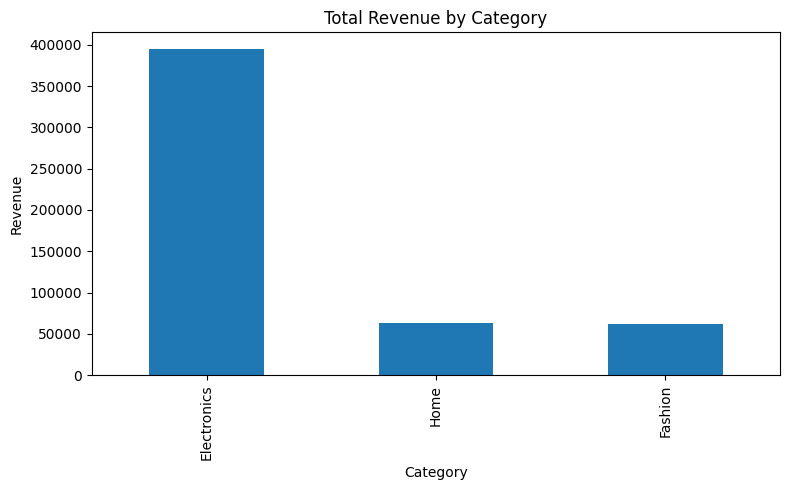

In [23]:
# Bar chart: revenue by category 
cat_revenue = sales_df.groupby('category').revenue.sum().sort_values(ascending=False)
plt.figure(figsize=(8,5))
cat_revenue.plot(kind='bar')
plt.title('Total Revenue by Category')
plt.ylabel('Revenue')
plt.xlabel('Category')
plt.tight_layout()
plt.show()

### Plot 2 — Heatmap: category × year revenue

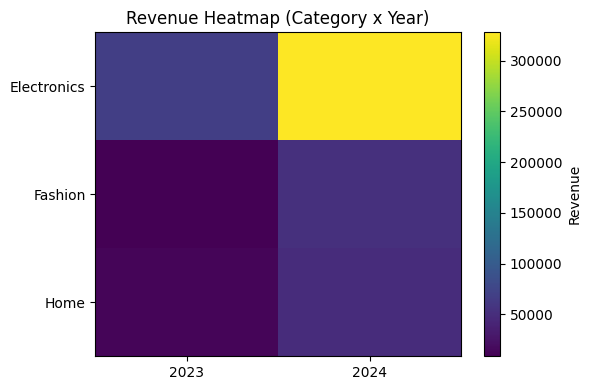

In [24]:
# Heatmap of cube (category vs year)
cube_no_all = cube.drop(index='All', errors='ignore').drop(columns='All', errors='ignore')
# convert to numeric matrix
mat = cube_no_all.fillna(0).astype(float).values

plt.figure(figsize=(6,4))
plt.imshow(mat, aspect='auto')   
plt.colorbar(label='Revenue')
plt.yticks(range(len(cube_no_all.index)), cube_no_all.index)
plt.xticks(range(len(cube_no_all.columns)), cube_no_all.columns)
plt.title('Revenue Heatmap (Category x Year)')
plt.tight_layout()
plt.show()

In [25]:
conn.close()